In [2]:
import tensorflow.compat.v1 as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=100

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "CDS",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3537 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['beginning stage', 'final stage', 'healthy']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 0 0 0 0 2 0 2 2 2 1 0 0 2 0 1 0 0 0 0 0 1 1 0 2 2 2 2 0 0 0]


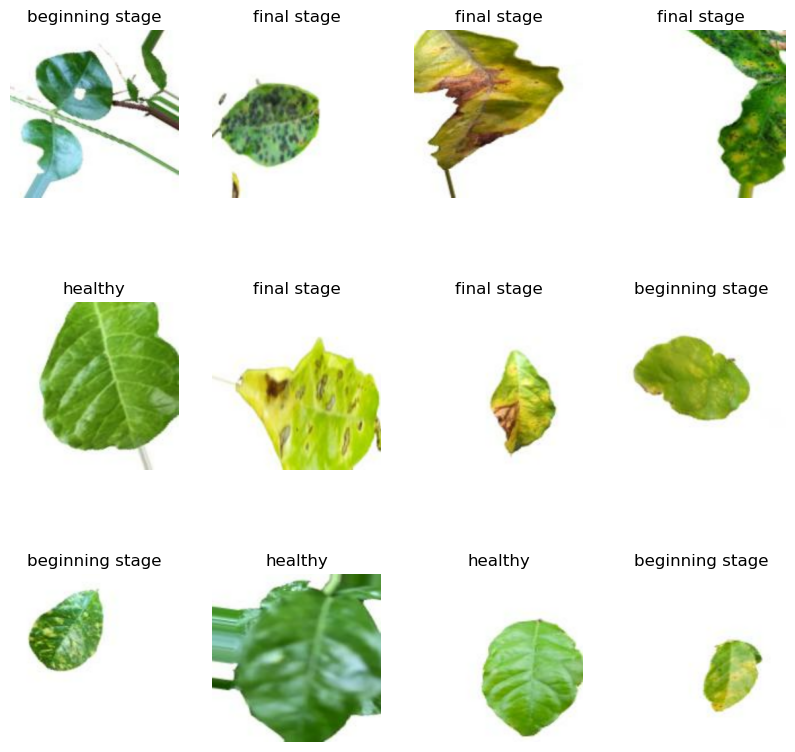

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)


111

In [13]:
train_size = 0.8
len(dataset)*train_size

88.80000000000001

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

57

In [16]:
val_size=0.1
len(dataset)*val_size

11.100000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

51

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

88

In [22]:
len(val_ds)

11

In [23]:
len(test_ds)

12

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [31]:
import tensorflow as tf


In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [35]:
import tensorflow.compat.v1 as tf

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100


88/88 [==============================] - 276s 3s/step - loss: 0.9687 - accuracy: 0.5316 - val_loss: 1.0109 - val_accuracy: 0.5045
Epoch 2/100
88/88 [==============================] - 207s 2s/step - loss: 0.8338 - accuracy: 0.5877 - val_loss: 0.7852 - val_accuracy: 0.5786
Epoch 3/100
88/88 [==============================] - 208s 2s/step - loss: 0.8075 - accuracy: 0.5941 - val_loss: 0.8298 - val_accuracy: 0.5816
Epoch 4/100
88/88 [==============================] - 208s 2s/step - loss: 0.7662 - accuracy: 0.5898 - val_loss: 0.8766 - val_accuracy: 0.4866
Epoch 5/100
88/88 [==============================] - 203s 2s/step - loss: 0.7328 - accuracy: 0.5994 - val_loss: 0.6424 - val_accuracy: 0.6617
Epoch 6/100
88/88 [==============================] - 200s 2s/step - loss: 0.6351 - accuracy: 0.6971 - val_loss: 0.5182 - val_accuracy: 0.7596
Epoch 7/100
88/88 [==============================] - 611s 7s/step - loss: 0.5712 - accuracy: 0.7340 - val_loss: 0.5416 - val_accuracy: 0.7567
Epoc

In [38]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 23s 338ms/step - loss: 0.0351 - accuracy: 0.9844


In [39]:
scores

[0.03510899096727371, 0.984375]

In [40]:
history

In [41]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 88}

In [42]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
type(history.history['loss'])

list

In [44]:
len(history.history['loss'])

100

In [45]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9687423706054688,
 0.83377605676651,
 0.8074848651885986,
 0.7661880850791931,
 0.7327560186386108]

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

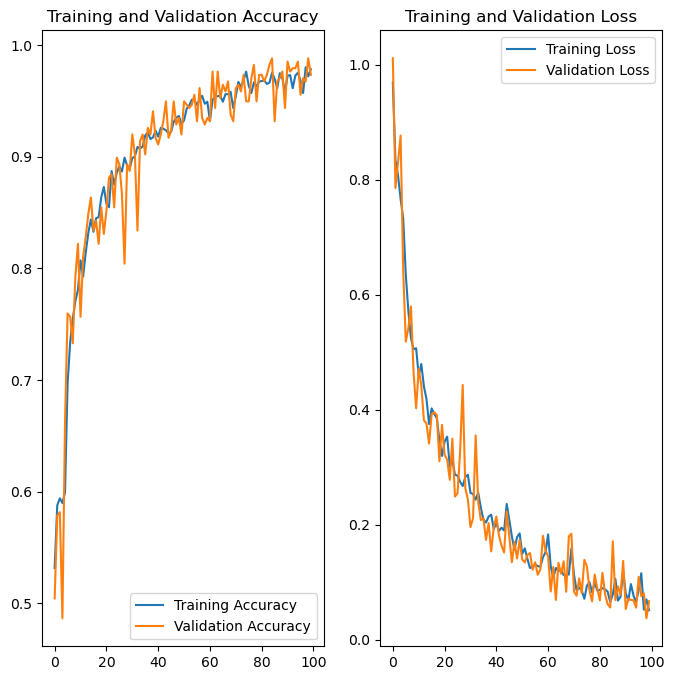

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: healthy
1/1 [==============================] - 1s 867ms/step
predicted label: healthy


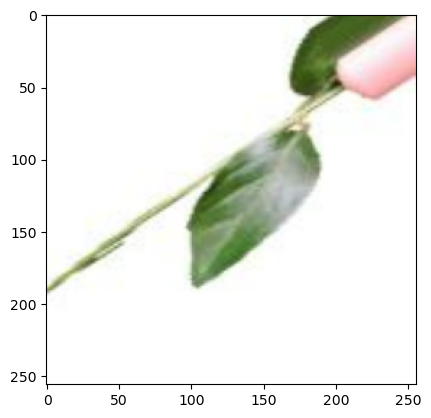

In [48]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


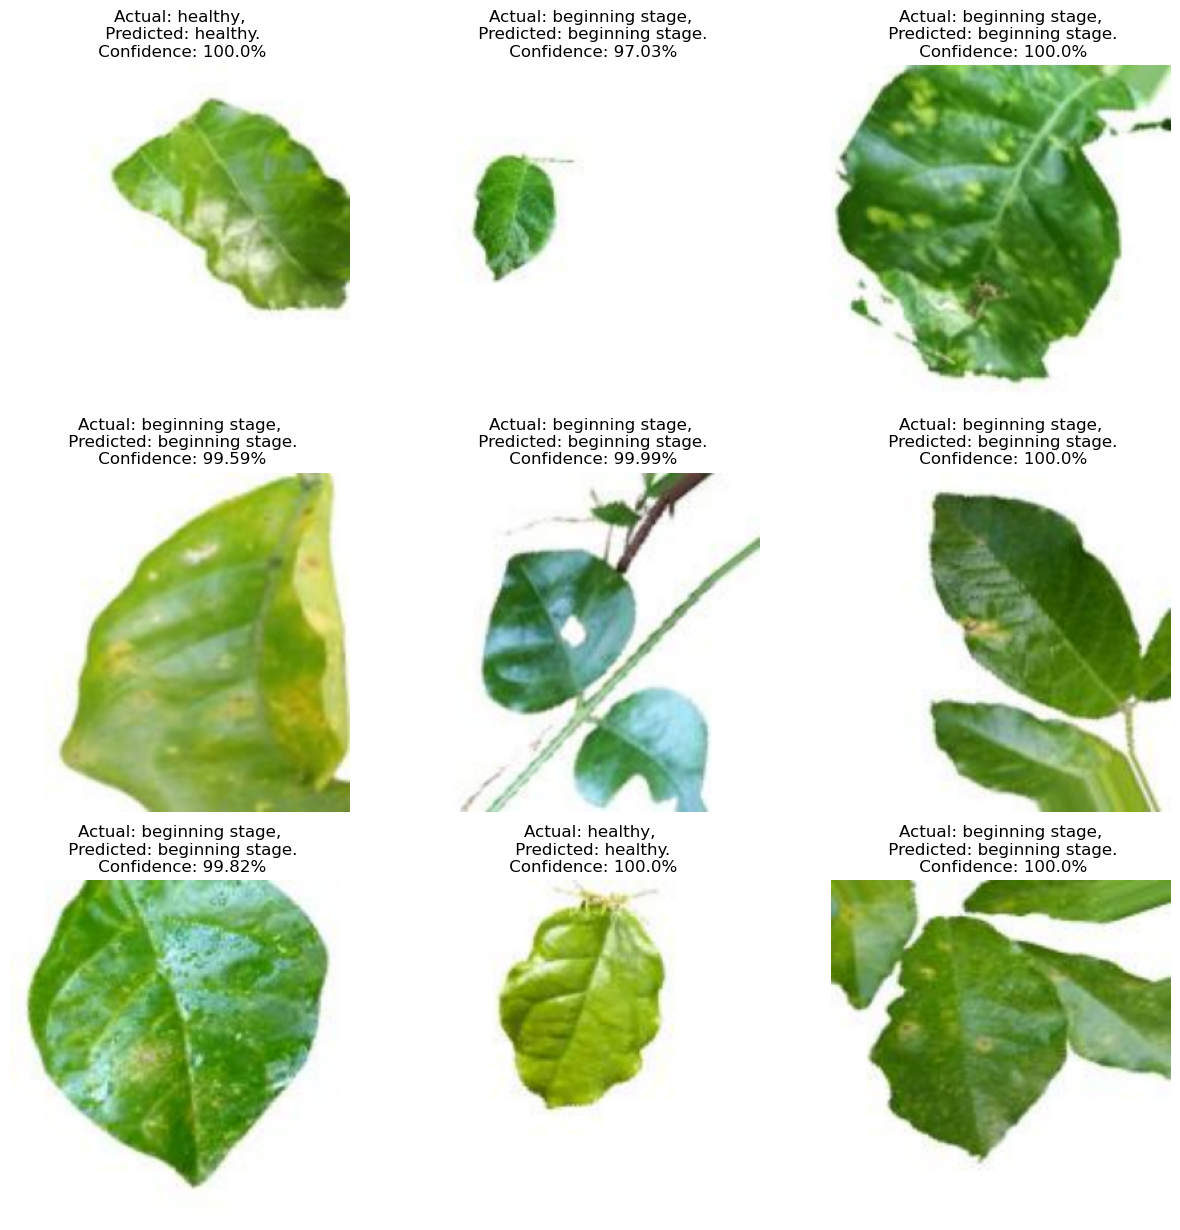

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [55]:
model.save("leaf.h5")

C:\Users\Apoorva\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
model.save('my_leaf_project')

INFO:tensorflow:Assets written to: my_leaf_project\assets


INFO:tensorflow:Assets written to: my_leaf_project\assets


Found 3537 files belonging to 3 classes.
1/1 [==============================] - 0s 93ms/step


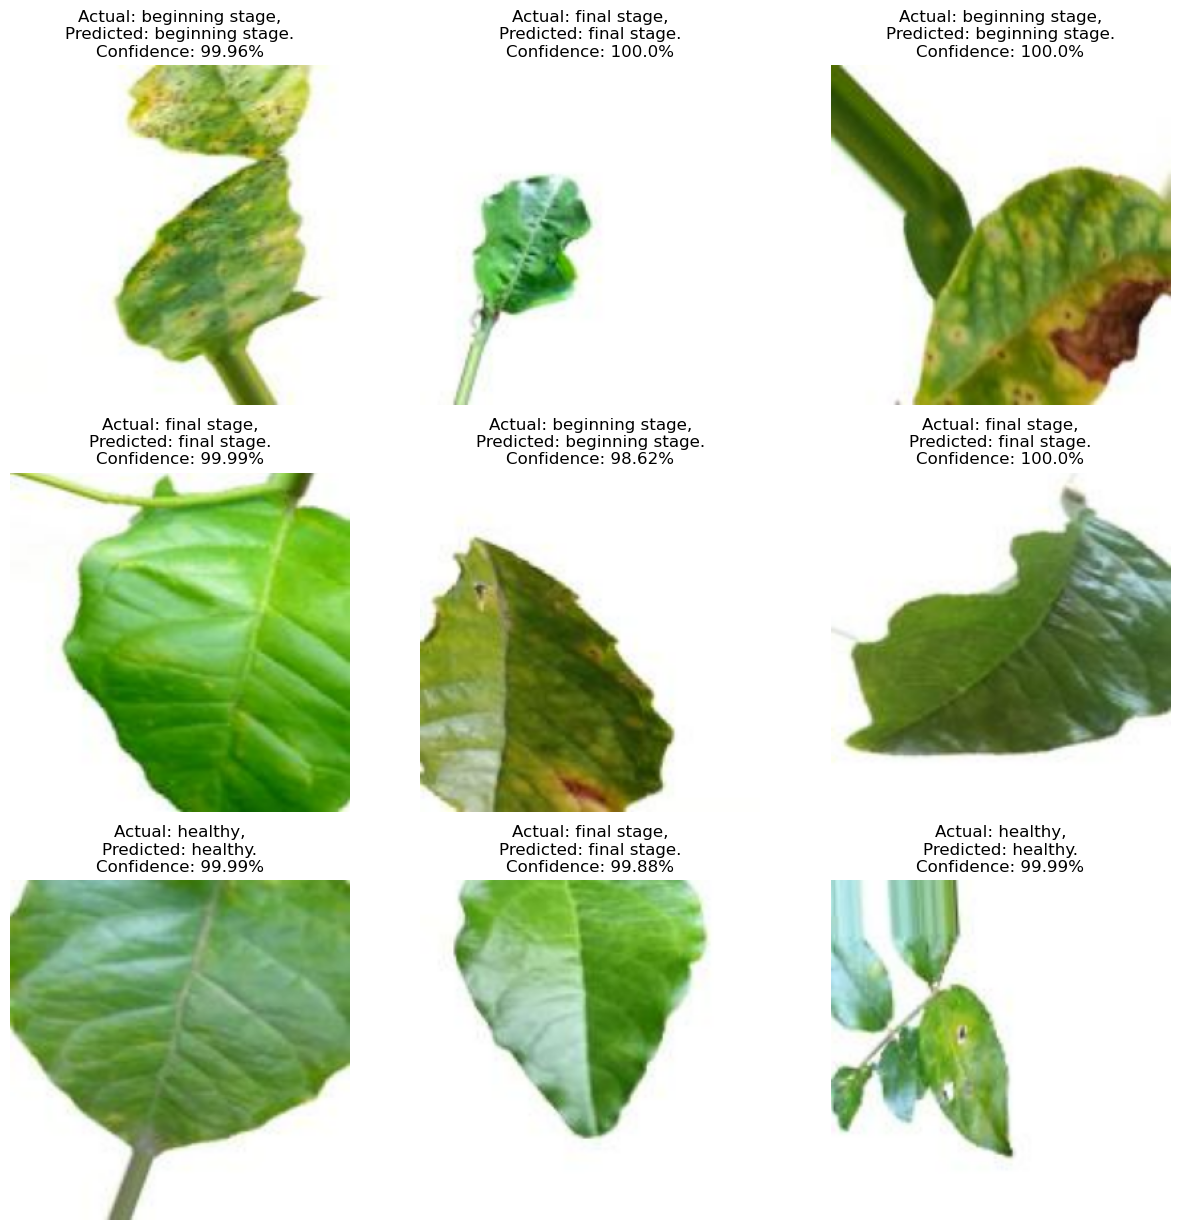

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('leaf.h5')

# Assuming 'class_names' are the labels used in training
class_names = ['healthy', 'beginning stage', 'final stage']  # Replace with your actual class names if different

# Reload the dataset (modify "CDS" to your dataset path if it's different)
BATCH_SIZE = 32
IMAGE_SIZE = 256

# Load the test dataset
# Assuming the dataset directory is "CDS" and structured correctly for image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "CDS",  # Replace with your dataset path
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Split the dataset (ensure same split as during training)
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

# Partition the dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Prefetch for performance
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Function to make a prediction
def predict(model, img):
    # Convert image to array and expand dimensions to match input shape
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    # Make predictions
    predictions = model.predict(img_array)

    # Get predicted class and confidence
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

# Visualize the predictions on the test dataset
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        
        plt.axis("off")

plt.show()


In [3]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("leaf.h5")

# Class names used in the model (update these based on your actual class names)
class_names = ['Beginning Stage', 'Final Stage', 'Healthy']

# Function to make predictions on the uploaded image
def predict_image(img_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Function to open file dialog and classify image
def classify_image():
    # Open file dialog
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    
    if file_path:
        # Display the selected image
        img = Image.open(file_path)
        img = img.resize((300, 300))  # Resize for display
        img_tk = ImageTk.PhotoImage(img)
        
        # Update the image panel
        panel.configure(image=img_tk)
        panel.image = img_tk
        
        # Show the borders after image is uploaded
        panel_frame.config(highlightthickness=2, relief="solid")  # Show border around image panel
        result_frame.config(highlightthickness=2, relief="solid")  # Show border around result panel
        
        # Make prediction
        predicted_class, confidence = predict_image(file_path)
        
        # Display the result
        result_text.set(f"Predicted: {predicted_class}\nConfidence: {confidence}%")

# Create the main application window
root = tk.Tk()
root.title("Leaf Disease Classifier")
root.geometry("600x800")  # Set the window size
root.configure(bg="#E9F3FB")  # Set the background color

# Title label with underline
title_label = tk.Label(root, text="Leaf Disease Classification", font=("Helvetica", 26, "bold", "underline"), fg="#0B2F9F", bg="#E9F3FB")
title_label.pack(pady=30)

# Instructions label
instructions_label = tk.Label(root, text="Upload an image of a leaf to classify its disease stage.", font=("Arial", 14), fg="#333333", bg="#E9F3FB")
instructions_label.pack(pady=10)

# Create and place a panel for displaying the uploaded image
panel_frame = tk.Frame(root, bg="#E9F3FB", bd=2, relief="flat", highlightbackground="#0B2F9F", highlightthickness=0)  # Match background color
panel_frame.pack(pady=20, padx=20)
panel = tk.Label(panel_frame, bg="#E9F3FB")  # Match background color
panel.pack(padx=10, pady=10)

# Create and place a button for uploading an image with rounded corners and a shadow effect
upload_btn = tk.Button(root, text="Upload Image", command=classify_image, bg="#4CAF50", fg="white", font=("Arial", 16), padx=20, pady=10, relief="raised", bd=5)
upload_btn.pack(pady=20)

# Create a label to display the prediction result with a border and padding
result_frame = tk.Frame(root, bg="#E9F3FB", bd=2, relief="flat", highlightbackground="#0B2F9F", highlightthickness=0)  # Match background color
result_frame.pack(pady=30)
result_text = tk.StringVar()
result_label = tk.Label(result_frame, textvariable=result_text, bg="#E9F3FB", font=("Arial", 18), fg="#0B2F9F", padx=20, pady=20)
result_label.pack()

# Add footer for credits or instructions
footer_label = tk.Label(root, text="Ensure the leaf is centered and well-lit for accurate results.", font=("Arial", 10), fg="#888888", bg="#E9F3FB")
footer_label.pack(side=tk.BOTTOM, pady=20)

# Start the Tkinter main loop
root.mainloop()


1/1 [==============================] - 0s 45ms/step
